# Import

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, label_binarize
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error, median_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(42)

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

rc = {'font.sans-serif': 'SimHei',
      'axes.unicode_minus': False}
sns.set(context='notebook', style='ticks', rc=rc)

import warnings
warnings.filterwarnings("ignore")


# Data


In [2]:
# data = pd.read_excel('./data/于小鹏 机器学习6.xlsx')
data = pd.read_excel('./data/于小鹏 机器学习5.xlsx')

In [3]:
data.head()

,总体生存时间,生存状态（编码）,feature_2,feature_3,feature_4,feature_5,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_26,feature_27,feature_28,TNM分期（编码汇总）,淋巴清扫
0,6.9079,0,0,1,58,1,1,5.68,51.2,43.1,3.2,42.3,1,19.0,14.9,42.1,11.9,1,2,2,0,3.2,1,0,1,0,1
1,18.5197,0,0,1,48,1,1,12.01,50.4,37.6,2.5,15.0,1,39.0,18.4,40.7,13.0,1,1,2,0,8.0,1,0,0,0,1
2,24.3092,0,0,2,76,0,1,8.99,52.1,37.0,1.7,1.8,0,19.0,14.0,41.9,12.6,1,1,1,0,5.1,1,0,1,0,1
3,9.4408,0,0,1,55,0,1,5.74,55.3,36.8,3.2,3.3,0,18.0,15.3,44.1,11.7,1,2,1,0,8.5,0,1,2,1,0
4,57.1053,1,0,1,51,1,1,9.02,60.3,32.8,3.7,2.1,0,12.0,14.4,41.0,10.9,1,2,2,0,4.7,1,1,1,0,1


In [4]:
data.drop(["生存状态（编码）", "TNM分期（编码汇总）"], axis=1, inplace=True)
data.describe()

,总体生存时间,feature_2,feature_3,feature_4,feature_5,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_26,feature_27,feature_28,淋巴清扫
count,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000,393.0000
mean,27.1679,0.2646,1.4707,57.5573,0.2774,0.3893,6.5801,7.6089,2.9878,29.3976,10.5374,0.5827,40.7850,29.9694,40.7513,11.8659,1.1120,2.3486,1.0967,0.3435,5.3715,0.4580,0.1578,1.3690,0.6921
std,21.8705,0.4417,0.4998,9.8197,0.4483,0.5878,2.1395,13.9802,6.0066,133.3235,34.8370,0.4937,49.4194,58.3024,5.3410,1.5293,0.3157,0.5874,0.2959,0.4755,2.8162,0.4989,0.3650,0.5879,0.4622
min,1.5000,0.0000,1.0000,27.0000,0.0000,0.0000,2.2800,1.3200,0.1500,0.6500,0.2000,0.0000,6.0000,3.6000,24.4000,1.1000,1.0000,1.0000,1.0000,0.0000,0.7000,0.0000,0.0000,0.0000,0.0000
25%,10.7333,0.0000,1.0000,50.0000,0.0000,0.0000,5.1100,3.1000,1.2100,2.1700,1.5600,0.0000,17.0000,10.5000,37.6000,10.8000,1.0000,2.0000,1.0000,0.0000,3.0000,0.0000,0.0000,1.0000,0.0000
50%,22.0000,0.0000,1.0000,59.0000,0.0000,0.0000,6.3000,4.0700,1.5800,3.2000,2.8900,1.0000,25.0000,13.4700,41.2000,11.7000,1.0000,2.0000,1.0000,0.0000,5.0000,0.0000,0.0000,1.0000,1.0000
75%,38.0000,1.0000,2.0000,64.0000,1.0000,1.0000,7.6500,5.4600,2.0300,6.4000,5.2400,1.0000,41.0000,19.2000,44.0000,12.7000,1.0000,3.0000,1.0000,1.0000,7.0000,1.0000,0.0000,2.0000,1.0000
max,120.0667,1.0000,2.0000,83.0000,1.0000,2.0000,15.3400,87.2000,43.1000,1404.0000,338.0000,1.0000,370.0000,400.3000,78.3000,18.7000,2.0000,3.0000,2.0000,1.0000,17.0000,1.0000,1.0000,2.0000,1.0000


<AxesSubplot:xlabel='feature_19', ylabel='总体生存时间'>

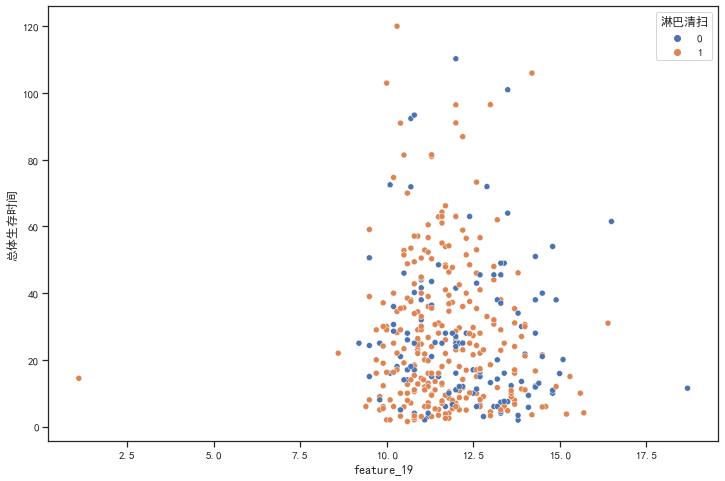

In [5]:
plt.figure(figsize=(12, 8))
# sns.scatterplot(x=original['feature_15'], y=original['总体生存时间'], hue=original['淋巴清扫'])
sns.scatterplot(x=data['feature_19'], y=data['总体生存时间'], hue=data['淋巴清扫'])

# preprocess

## Deal with raw data

In [6]:
def get_class(target):
    if target < 12:
        return 0
    elif target < 24:
        return 1
    elif target < 36:
        return 2
    elif target < 48:
        return 3
    elif target < 60:
        return 4
    else:
        return 5

data['总体生存时间'] = data['总体生存时间'].apply(get_class)

<AxesSubplot:>

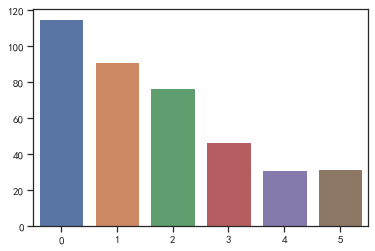

In [7]:
sns.barplot(y=data['总体生存时间'].value_counts().values, x=data['总体生存时间'].value_counts().index)

In [8]:
df = data.copy()

with_ = df[df['淋巴清扫'] == 1]
without_ = df[df['淋巴清扫'] == 0]

# with_ = pd.DataFrame(with_, columns=with_ftr)
# without_ = pd.DataFrame(without_, columns=without_ftr)

with_.drop(['淋巴清扫'], axis=1, inplace=True)
without_.drop(['淋巴清扫'], axis=1, inplace=True)

In [9]:
with_

,总体生存时间,feature_2,feature_3,feature_4,feature_5,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_26,feature_27,feature_28
0,0,0,1,58,1,1,5.68,51.20,43.10,3.20,42.30,1,19.0,14.90,42.10,11.9,1,2,2,0,3.2,1,0,1
1,1,0,1,48,1,1,12.01,50.40,37.60,2.50,15.00,1,39.0,18.40,40.70,13.0,1,1,2,0,8.0,1,0,0
2,2,0,2,76,0,1,8.99,52.10,37.00,1.70,1.80,0,19.0,14.00,41.90,12.6,1,1,1,0,5.1,1,0,1
4,4,0,1,51,1,1,9.02,60.30,32.80,3.70,2.10,0,12.0,14.40,41.00,10.9,1,2,2,0,4.7,1,1,1
5,1,0,2,45,1,1,5.79,60.40,31.80,1.60,9.20,1,37.0,7.90,43.10,11.6,1,2,1,0,9.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,0,0,1,59,0,0,6.20,4.80,0.78,15.64,4.79,1,20.0,12.70,43.70,13.6,1,2,1,0,10.9,1,0,1
385,2,0,1,61,1,1,6.88,5.36,0.72,17.00,1.45,1,17.0,12.70,41.40,12.6,1,3,1,0,10.0,0,0,1
386,0,1,2,47,0,0,4.63,3.63,0.69,2.35,3.45,1,74.0,46.20,38.40,13.5,1,3,1,1,4.5,1,0,2
387,4,0,2,75,0,1,4.96,2.82,0.67,11.20,3.25,1,18.8,11.60,35.00,9.5,1,2,1,1,10.0,0,0,1


## Nomalization

In [10]:
# scaler = StandardScaler()
scaler = MinMaxScaler()

def scale(scaler, df):
    x = df.iloc[:, 1:].values
    y = df.iloc[:, 0].values
    
    x = scaler.fit_transform(x)
    # y = scaler.fit_transform(y.reshape(-1, 1))
    return x, y

In [11]:
with_x, with_y = scale(scaler, with_)
without_x, without_y = scale(scaler, without_)


## Split into training set and test set

In [12]:
with_train_x, with_valid_x, with_train_y, with_valid_y = train_test_split(with_x, with_y, test_size=0.1, random_state=1)
without_train_x, without_valid_x, without_train_y, without_valid_y = train_test_split(without_x, without_y, test_size=0.1, random_state=1)
with_train_x.shape, with_valid_x.shape


((244, 23), (28, 23))

In [13]:
without_train_x.shape, without_valid_x.shape

((108, 23), (13, 23))

# Model

In [14]:
def clf_model_eval(model, x, y, valid_x, valid_y):
    model.fit(x, y)
    pred = model.predict(valid_x)
    proba = model.predict_proba(valid_x)

    acc = accuracy_score(valid_y, pred)
    precision = precision_score(valid_y, pred, average="macro")
    recall = recall_score(valid_y, pred, average="macro")
    f1 = f1_score(valid_y, pred, average="macro")
    auc = roc_auc_score(valid_y, proba, multi_class="ovo", labels=[0, 1, 2, 3, 4, 5])
    return acc, precision, recall, f1, auc


def reg_model_eval(model, x, y, valid_x, valid_y):
    model.fit(x, y)
    pred = model.predict(valid_x)

    r2 = r2_score(valid_y, pred)
    evs = explained_variance_score(valid_y, pred)
    mse = mean_squared_error(valid_y, pred)
    mae = mean_absolute_error(valid_y, pred)
    mdae = median_absolute_error(valid_y, pred)
    return r2, evs, mse, mae, mdae, pred

In [15]:
reg = {
    "LinearRegression": LinearRegression(),
    "NeuralNetwork": MLPRegressor(learning_rate="adaptive", max_iter=500),
    "SupportVectorMachine": SVR(),
    "RandomForest": RandomForestRegressor(),
    "KNeighbors": KNeighborsRegressor(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
}

clf = {
    "MLP": MLPClassifier(learning_rate="adaptive", max_iter=500),
    "SupportVectorMachine": SVC(probability=True),
    "RandomForest": RandomForestClassifier(),
    "KNeighbors": KNeighborsClassifier(),
}

# Results of classification

In [16]:
with_clf_results = {}
without_clf_results = {}

for name, model in clf.items():
    acc, precision, recall, f1, auc_ = clf_model_eval(
        model,
        with_train_x,
        with_train_y,
        with_valid_x,
        with_valid_y
    )
    with_clf_results[name] = [acc, precision, recall, f1, auc_]
for name, model in clf.items():
    acc, precision, recall, f1, auc_ = clf_model_eval(
        model,
        without_train_x,
        without_train_y,
        without_valid_x,
        without_valid_y
    )
    without_clf_results[name] = [acc, precision, recall, f1, auc_]

In [17]:
df1 = pd.DataFrame(with_clf_results, index=['accuracy', 'precision', 'recall', 'f1_score', 'AUC'])
df1.T

,accuracy,precision,recall,f1_score,AUC
MLP,0.4286,0.5491,0.3726,0.3658,0.6855
SupportVectorMachine,0.2500,0.0486,0.1667,0.0753,0.4921
RandomForest,0.3214,0.2056,0.2238,0.1832,0.6802
KNeighbors,0.3929,0.3611,0.3115,0.2911,0.7146


In [18]:
df2 = pd.DataFrame(without_clf_results, index=['accuracy', 'precision', 'recall', 'f1_score', 'AUC'])
df2.T

,accuracy,precision,recall,f1_score,AUC
MLP,0.1538,0.15,0.1667,0.1571,0.4611
SupportVectorMachine,0.3077,0.15,0.2000,0.1527,0.2917
RandomForest,0.4615,0.40,0.3000,0.3333,0.5444
KNeighbors,0.2308,0.20,0.1333,0.1556,0.5174


# Results of regression

In [19]:
with_reg_results = {}
with_preds = []
without_reg_results = {}
without_preds = []

for name, model in reg.items():
    r2, evs, mse, mae, mdae, pred = reg_model_eval(
        model,
        with_train_x,
        with_train_y,
        with_valid_x,
        with_valid_y
    )
    with_reg_results[name] = [r2, evs, mse, mae, mdae]
    with_preds.append(pred)

for name, model in reg.items():
    r2, evs, mse, mae, mdae, pred = reg_model_eval(
        model,
        without_train_x,
        without_train_y,
        without_valid_x,
        without_valid_y
    )
    without_reg_results[name] = [r2, evs, mse, mae, mdae]
    without_preds.append(pred)

In [20]:
# r2, evs, mse, mae, mdae

mean_preds = np.array(with_preds).sum(axis=0) / 8
r2 = r2_score(with_valid_y, mean_preds)
evs = explained_variance_score(with_valid_y, mean_preds)
mse = mean_squared_error(with_valid_y, mean_preds)
mae = mean_absolute_error(with_valid_y, mean_preds)
mdae = median_absolute_error(with_valid_y, mean_preds)

df_ = pd.DataFrame([r2, evs, mse, mae, mdae], index=["R2 score", "explained variance score", "mean squared error", "mean absolute error", "median absolute error"])
df1 = pd.DataFrame(with_reg_results, index=["R2 score", "explained variance score", "mean squared error", "mean absolute error", "median absolute error"])
df1 = pd.concat([df1, df_], axis=1)
df1.rename(columns={0: "Mean Ensemble"}, inplace=True)
df1.T

,R2 score,explained variance score,mean squared error,mean absolute error,median absolute error
LinearRegression,0.0171,0.1494,3.2535,1.5403,1.3508
NeuralNetwork,-0.0554,0.0907,3.4932,1.5125,1.2534
SupportVectorMachine,0.0885,0.3026,3.0170,1.4352,1.3334
RandomForest,-0.0542,0.0375,3.4892,1.5779,1.3000
KNeighbors,0.1062,0.2073,2.9586,1.3929,1.2000
Ridge,0.1241,0.2324,2.8993,1.4562,1.2923
Lasso,-0.0616,0.0000,3.5137,1.6071,1.6557
ElasticNet,-0.0616,0.0000,3.5137,1.6071,1.6557
Mean Ensemble,0.1142,0.2243,2.9320,1.4669,1.2942


In [21]:
mean_preds = np.array(without_preds).sum(axis=0) / 8
r2 = r2_score(without_valid_y, mean_preds)
evs = explained_variance_score(without_valid_y, mean_preds)
mse = mean_squared_error(without_valid_y, mean_preds)
mae = mean_absolute_error(without_valid_y, mean_preds)
mdae = median_absolute_error(without_valid_y, mean_preds)

df_ = pd.DataFrame([r2, evs, mse, mae, mdae], index=["R2 score", "explained variance score", "mean squared error", "mean absolute error", "median absolute error"])
df2 = pd.DataFrame(without_reg_results, index=["R2 score", "explained variance score", "mean squared error", "mean absolute error", "median absolute error"])
df2 = pd.concat([df2, df_], axis=1)
df2.rename(columns={0: "Mean Ensemble"}, inplace=True)
df2.T

,R2 score,explained variance score,mean squared error,mean absolute error,median absolute error
LinearRegression,-0.2026,-0.0050,2.8037,1.3644,1.0555
NeuralNetwork,-0.6346,-0.2542,3.8107,1.4420,1.3194
SupportVectorMachine,0.1832,0.2457,1.9042,1.1173,0.8954
RandomForest,0.0206,0.0369,2.2833,1.2162,0.9400
KNeighbors,-0.0004,0.3180,2.3323,1.2923,1.6000
Ridge,-0.0736,0.0835,2.5028,1.2866,0.8714
Lasso,-0.1240,0.0000,2.6205,1.4494,1.7685
ElasticNet,-0.1240,0.0000,2.6205,1.4494,1.7685
Mean Ensemble,-0.0056,0.1449,2.3444,1.3008,0.9803


# Plot

In [23]:
with_predictions = {}
without_predictions = {}

for name, model in clf.items():
    model.fit(with_train_x, with_train_y)
    model.fit(without_train_x, without_train_y)
    w_pred = model.predict_proba(with_valid_x)
    wo_pred = model.predict_proba(without_valid_x)
    with_predictions[name] = w_pred
    without_predictions[name] = wo_pred

针对多类数据的ROC曲线的可视化方式有两种：

第一种为：采用将原始数据的真实类别标签矩阵和模型预测得到的概率矩阵分别按行展开，转置后形成两列，这就可以近似的看作获得了一个二分类的结果，进而可以可视化ROC曲线。

第二种方式为：将每类一类数据和其他类别的数据看作为一个二分类类的数据模型，然后对数据可视化ROC曲线。为了方便计算每一类样本的ROC曲线的相关取值，可以将类别标签使用label_binarize进行编码。

In [24]:
with_y_test = label_binarize(with_valid_y, classes=[0, 1, 2, 3, 4, 5]) # shape==(28, 3)
without_y_test = label_binarize(with_valid_y, classes=[0, 1, 2, 3, 4, 5]) # shape==(13, 3)

w_fpr = {}
w_tpr = {}
w_roc_auc = []
wo_fpr = {}
wo_tpr = {}
wo_roc_auc = []

for name, pred in with_predictions.items():
    w_fpr[name], w_tpr[name], _ = roc_curve(with_y_test.ravel(), pred.ravel())
    w_roc_auc.append(auc(w_fpr[name], w_tpr[name]))
    wo_fpr[name], wo_tpr[name], _ = roc_curve(without_y_test.ravel(), pred.ravel())
    wo_roc_auc.append(auc(wo_fpr[name], wo_tpr[name]))



In [25]:
def draw_roc(fpr, tpr, roc_auc, switch=True):
    plt.figure(figsize=(12, 8))
    lw = 2
    plt.plot(
        fpr["MLP"],
        tpr["MLP"],
        color='#de7e5d',
        lw=lw,
        label="MLP_AUC (area = %0.2f)" % roc_auc[0],
    )
    plt.plot(
        fpr["SupportVectorMachine"],
        tpr["SupportVectorMachine"],
        color='#05696b',
        lw=lw,
        label="SupportVectorMachine_AUC (area = %0.2f)" % roc_auc[1],
    )
    plt.plot(
        fpr["RandomForest"],
        tpr["RandomForest"],
        color='#825f87',
        lw=lw,
        label="RandomForest_AUC (area = %0.2f)" % roc_auc[2],
    )
    plt.plot(
        fpr["KNeighbors"],
        tpr["KNeighbors"],
        color='seagreen',
        lw=lw,
        label="KNeighbors_AUC (area = %0.2f)" % roc_auc[3],
    )
    plt.plot([0, 1], [0, 1], color="#9DA9B4", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    if switch:
        plt.title(f"ROC Curve of Different Models（清扫组）", fontsize=20)
    else:
        plt.title("ROC Curve of Different Models（未清扫组）", fontsize=20)
    plt.legend(loc="lower right")
    plt.show()

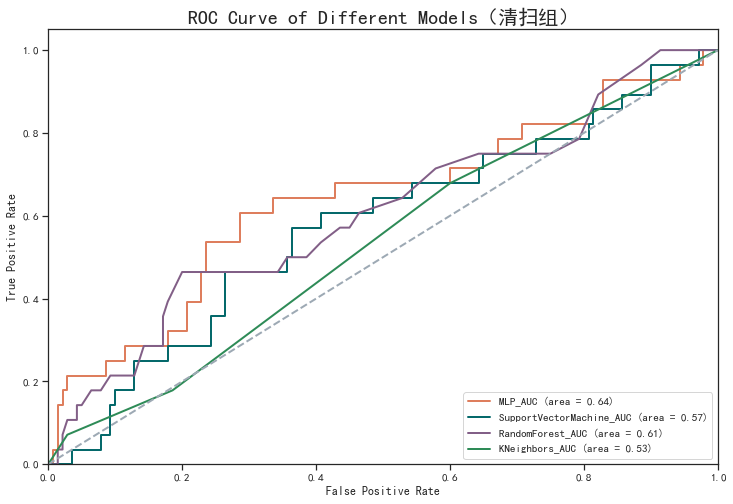

In [26]:
draw_roc(w_fpr, w_tpr, w_roc_auc)

# Ensemble

## Stacking

In [37]:
from sklearn.ensemble import StackingRegressor

estimators = [

    ("NeuralNetwork", MLPRegressor(learning_rate="adaptive", max_iter=500)),
    ("SupportVectorMachine", SVR()),
    ("RandomForest", RandomForestRegressor()),
    ("KNeighbors", KNeighborsRegressor()),
    ("ElasticNet", ElasticNet()),
    ("LGBM", gbm),

]

ensemble_regressor = StackingRegressor(
    estimators=estimators,
    # final_estimator=RidgeCV(), by default
)

ensemble_regressor.fit(with_train_x, with_train_y)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=8500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8500
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=3.9195751521803652, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9195751521803652
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_l

StackingRegressor(estimators=[('NeuralNetwork',
                               MLPRegressor(learning_rate='adaptive',
                                            max_iter=500)),
                              ('SupportVectorMachine', SVR()),
                              ('RandomForest', RandomForestRegressor()),
                              ('KNeighbors', KNeighborsRegressor()),
                              ('ElasticNet', ElasticNet()),
                              ('LGBM',
                               LGBMRegressor(bagging_fraction=0.9,
                                             bagging_freq=1,
                                             feature_fraction=0.6000000000000001,
                                             lambda_l1=0, lambda_l2=0,
                                             learning_rate=0.2455074893970599,
                                             max_depth=5, min_data_in_leaf=8500,
                                             min_gain_to_split=3.919575152180

In [38]:
pred = ensemble_regressor.predict(with_valid_x)

r2 = r2_score(with_valid_y, pred)
evs = explained_variance_score(with_valid_y, pred)
mse = mean_squared_error(with_valid_y, pred)
mae = mean_absolute_error(with_valid_y, pred)
mdae = median_absolute_error(with_valid_y, pred)

In [39]:
ensemble_results = r2, evs, mse, mae, mdae
df3 = pd.DataFrame(ensemble_results, index=["R2_score", "explained_variance_score", "mean squared error", "mean absolute error", "median absolute error"])
df3.columns = ["Ensemble"]
df3.T

,R2_score,explained_variance_score,mean squared error,mean absolute error,median absolute error
Ensemble,0.0561,0.1486,3.1242,1.5145,1.4023


## LGBM

In [30]:
import lightgbm as lgb

In [31]:
import optuna  # pip install optuna
from sklearn.model_selection import StratifiedKFold
from optuna.integration import LightGBMPruningCallback

def objective(trial, X, y):
    # 参数网格
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.95, step=0.1),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.1),
        "random_state": 2021,
    }
    # 5折交叉验证
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # LGBM建模
        model = lgb.LGBMRegressor(objective="regression", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="l1",
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "l1")
            ],
        )
        # 模型预测
        preds = model.predict(X_test)
        # 优化指标logloss最小
        cv_scores[idx] = mean_squared_error(y_test, preds)

    return np.mean(cv_scores)

In [ ]:
study = optuna.create_study(direction="minimize", study_name="LGBM")
func = lambda trial: objective(trial, with_train_x, with_train_y)
study.optimize(func, n_trials=20)

In [33]:
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (rmse): 2.43048
	Best params:
		n_estimators: 10000
		learning_rate: 0.2455074893970599
		num_leaves: 2160
		max_depth: 5
		min_data_in_leaf: 8500
		lambda_l1: 0
		lambda_l2: 0
		min_gain_to_split: 3.9195751521803652
		bagging_fraction: 0.9
		bagging_freq: 1
		feature_fraction: 0.6000000000000001


In [34]:
gbm = lgb.LGBMRegressor(
    objective="regression", **study.best_params
)

gbm.fit(
    with_train_x,
    with_train_y,
    eval_set=[(with_valid_x, with_valid_y)],
    eval_metric="l1",
    early_stopping_rounds=5,
)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=8500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8500
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=3.9195751521803652, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9195751521803652
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[1]	valid_0's l1: 1.93267	valid_0's l2: 4.76037
[2]	valid_0's l1: 1.93267	valid_0's l2: 4.76037
[3]	valid_0's l1: 1.93267	valid_0's l2: 4.7603

LGBMRegressor(bagging_fraction=0.9, bagging_freq=1,
              feature_fraction=0.6000000000000001, lambda_l1=0, lambda_l2=0,
              learning_rate=0.2455074893970599, max_depth=5,
              min_data_in_leaf=8500, min_gain_to_split=3.9195751521803652,
              n_estimators=10000, num_leaves=2160, objective='regression')

In [36]:
y_pred = gbm.predict(with_valid_x, num_iteration=gbm.best_iteration_)

print(mean_squared_error(with_valid_y, y_pred) ** 0.5)

1.8744907551244294
